In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

In [2]:
movies = pd.read_csv('cleaned_movies.csv')
ratings = pd.read_csv('user_movie_ratings_transformed.csv')

In [3]:
movies.head()

,id,title,keywords,overview,genres,popularity,vote_average,vote_count
0,19995,Avatar,"['culture clash', 'future', 'space war', 'spac...","In the 22nd century, a paraplegic Marine is di...","['Action', 'Adventure', 'Fantasy', 'Science Fi...",150.437577,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"['ocean', 'drug abuse', 'exotic island', 'east...","Captain Barbossa, long believed to be dead, ha...","['Adventure', 'Fantasy', 'Action']",139.082615,6.9,4500
2,206647,Spectre,"['spy', 'based on novel', 'secret agent', 'seq...",A cryptic message from Bond’s past sends him o...,"['Action', 'Adventure', 'Crime']",107.376788,6.3,4466
3,49026,The Dark Knight Rises,"['dc comics', 'crime fighter', 'terrorist', 's...",Following the death of District Attorney Harve...,"['Action', 'Crime', 'Drama', 'Thriller']",112.312950,7.6,9106
4,49529,John Carter,"['based on novel', 'mars', 'medallion', 'space...","John Carter is a war-weary, former military ca...","['Action', 'Adventure', 'Science Fiction']",43.926995,6.1,2124


In [4]:
ratings.head()

,user,id,final_rating
0,A3TS466QBAWB9D,9693,9
1,A3BUDYITWUSIS7,103328,9
2,A19K10Z0D2NTZK,3021,9
3,A14X336IB4JD89,8470,4
4,A2HR0IL3TC4CKL,109445,9


In [5]:
movies = movies[[col for col in movies.columns if col not in ['vote_count', 'vote_average', 'overview']]]

movies.head()

,id,title,keywords,genres,popularity
0,19995,Avatar,"['culture clash', 'future', 'space war', 'spac...","['Action', 'Adventure', 'Fantasy', 'Science Fi...",150.437577
1,285,Pirates of the Caribbean: At World's End,"['ocean', 'drug abuse', 'exotic island', 'east...","['Adventure', 'Fantasy', 'Action']",139.082615
2,206647,Spectre,"['spy', 'based on novel', 'secret agent', 'seq...","['Action', 'Adventure', 'Crime']",107.376788
3,49026,The Dark Knight Rises,"['dc comics', 'crime fighter', 'terrorist', 's...","['Action', 'Crime', 'Drama', 'Thriller']",112.312950
4,49529,John Carter,"['based on novel', 'mars', 'medallion', 'space...","['Action', 'Adventure', 'Science Fiction']",43.926995


In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4795 entries, 0 to 4794
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          4795 non-null   int64  
 1   title       4795 non-null   object 
 2   keywords    4795 non-null   object 
 3   genres      4795 non-null   object 
 4   popularity  4795 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 187.4+ KB


In [7]:
print(movies['genres'].iloc[0])
print(type(movies['genres'].iloc[0]))

print(movies['keywords'].iloc[0])
print(type(movies['keywords'].iloc[0]))


['Action', 'Adventure', 'Fantasy', 'Science Fiction']
<class 'str'>
['culture clash', 'future', 'space war', 'space colony', 'society', 'space travel', 'futuristic', 'romance', 'space', 'alien', 'tribe', 'alien planet', 'cgi', 'marine', 'soldier', 'battle', 'love affair', 'anti war', 'power relations', 'mind and soul', '3d']
<class 'str'>


# Processing movies

In [8]:
import ast

def safe_parse_list(x):
    if not isinstance(x, str):
        return x

    x = x.strip()

    if x.startswith("[") and x.endswith("]"):
        try:
            return ast.literal_eval(x)
        except:
            return []

    return []

In [9]:
movies['genres_combined'] = movies['genres'].apply(safe_parse_list)
movies['keywords_combined'] = movies['keywords'].apply(safe_parse_list)

In [10]:
movies['genres_combined'] = movies['genres_combined'].apply(lambda x: " ".join(x))
movies['keywords_combined'] = movies['keywords_combined'].apply(lambda x: " ".join(x))

In [12]:
movies['text_features'] = movies['genres_combined'] + " " + movies['keywords_combined']

In [13]:
movies.head()

,id,title,keywords,genres,popularity,genres_combined,keywords_combined,text_features
0,19995,Avatar,"['culture clash', 'future', 'space war', 'spac...","['Action', 'Adventure', 'Fantasy', 'Science Fi...",150.437577,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,Action Adventure Fantasy Science Fiction cultu...
1,285,Pirates of the Caribbean: At World's End,"['ocean', 'drug abuse', 'exotic island', 'east...","['Adventure', 'Fantasy', 'Action']",139.082615,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,Adventure Fantasy Action ocean drug abuse exot...
2,206647,Spectre,"['spy', 'based on novel', 'secret agent', 'seq...","['Action', 'Adventure', 'Crime']",107.376788,Action Adventure Crime,spy based on novel secret agent sequel mi6 bri...,Action Adventure Crime spy based on novel secr...
3,49026,The Dark Knight Rises,"['dc comics', 'crime fighter', 'terrorist', 's...","['Action', 'Crime', 'Drama', 'Thriller']",112.312950,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,Action Crime Drama Thriller dc comics crime fi...
4,49529,John Carter,"['based on novel', 'mars', 'medallion', 'space...","['Action', 'Adventure', 'Science Fiction']",43.926995,Action Adventure Science Fiction,based on novel mars medallion space travel pri...,Action Adventure Science Fiction based on nove...


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(movies['text_features'])

# Graph

In [15]:
import networkx as nx

G = nx.Graph()

# Tambah node movie
for idx, row in movies.iterrows():
    G.add_node(f"m_{row['id']}", type="movie", features=tfidf_matrix[idx])

# Tambah node user
for u in ratings['user'].unique():
    G.add_node(f"u_{u}", type="user")

In [16]:
for _, row in ratings.iterrows():
    G.add_edge(
        f"u_{row['user']}",
        f"m_{row['id']}",
        weight=row['final_rating']
    )

## Visualisasi graph for sample user

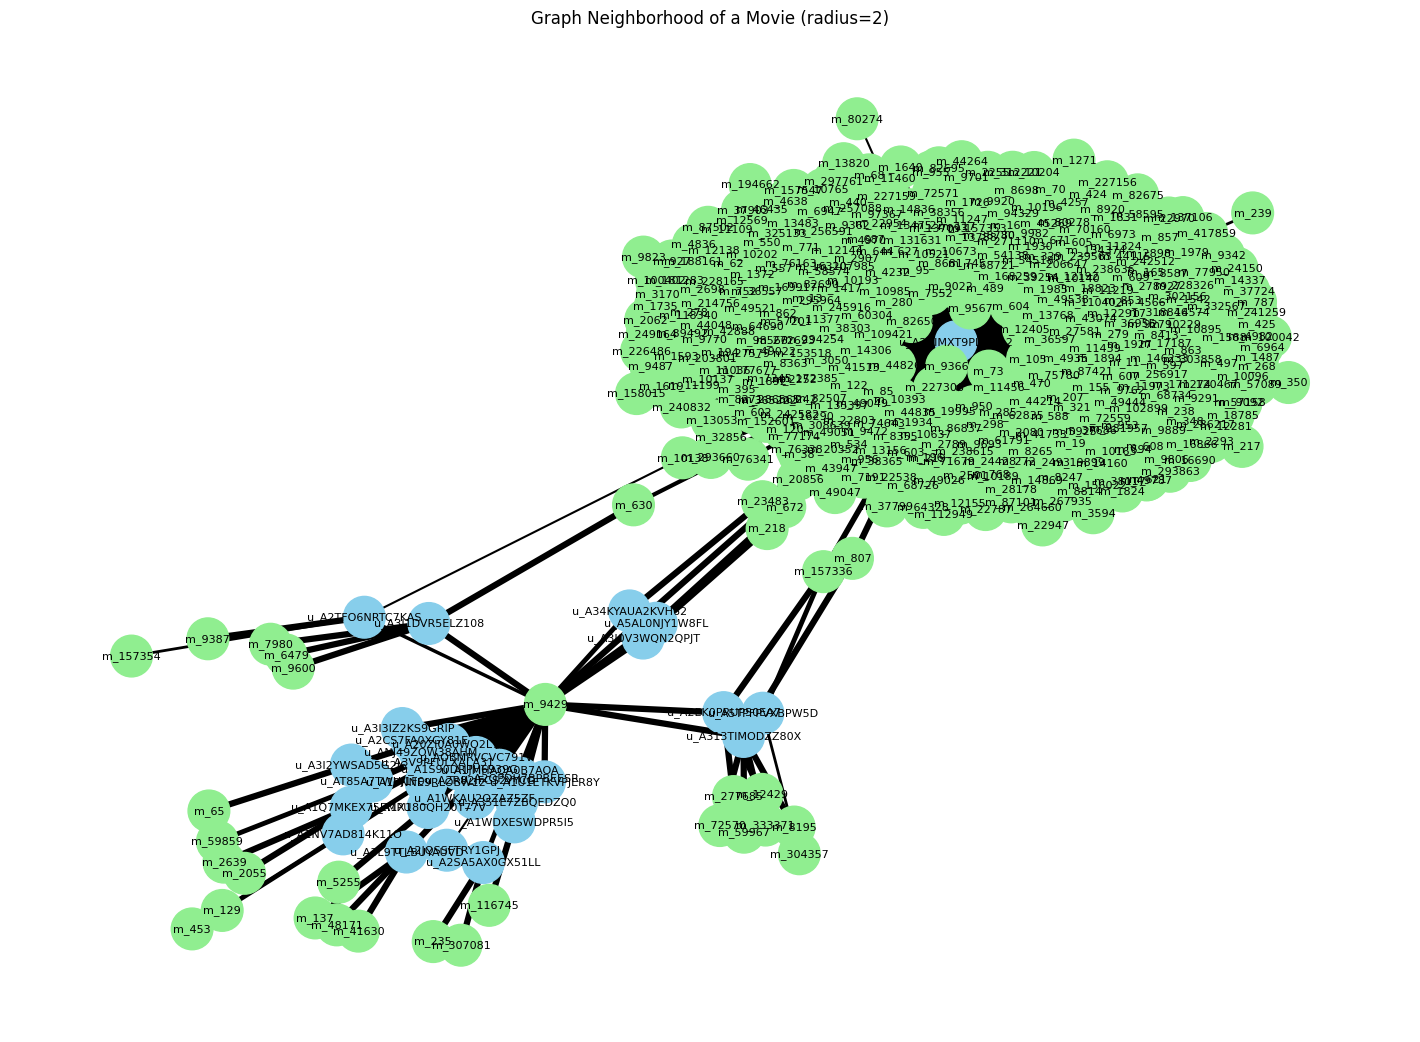

In [23]:
# Pilih movie random
random_movie = f"m_{movies.sample(1)['id'].values[0]}"

# Ambil graf radius 2
H2 = nx.ego_graph(G, random_movie, radius=2)

# Visualisasi
plt.figure(figsize=(14,10))
pos = nx.spring_layout(H2, seed=42)

color_map = ['skyblue' if G.nodes[n]['type']=='user' else 'lightgreen' for n in H2.nodes()]
edge_widths = [H2[u][v]['weight']/2 for u,v in H2.edges()]

nx.draw(H2, pos,
        with_labels=True,
        node_color=color_map,
        node_size=900,
        width=edge_widths,
        font_size=8)

plt.title("Graph Neighborhood of a Movie (radius=2)")
plt.show()


## Graph processing

In [30]:
# ambil movies yang sudah ditonton user
def get_watched_movies(user_id):
    neighbors = list(G.neighbors(f"u_{user_id}"))
    watched = [n for n in neighbors if n.startswith("m_")]
    return watched

In [31]:
# hitung kemiripan
from sklearn.metrics.pairwise import cosine_similarity

movie_sim = cosine_similarity(tfidf_matrix)

In [42]:
def recommend_weighted_hybrid(user_id, k=10):
    user_node = f"u_{user_id}"

    # Cek apakah user ada di graf
    if not G.has_node(user_node):
        print(f"User {user_id} tidak ditemukan.")
        return []

    # Ambil film yang sudah ditonton beserta ratingnya
    watched_movies = []
    for neighbor in G.neighbors(user_node):
        if neighbor.startswith("m_"):
            rating = G[user_node][neighbor]['weight']
            movie_id_int = int(neighbor.replace("m_", ""))
            watched_movies.append((movie_id_int, rating))

    # Jika user belum pernah rating, kembalikan Top Popularity
    if not watched_movies:
        print("User baru (Cold Start), memberikan rekomendasi populer.")
        return movies.sort_values('popularity', ascending=False).head(k)[['id', 'title', 'genres', 'popularity']]

    # array skor
    total_scores = np.zeros(len(movies))

    # Mapping ID film ke Index DataFrame
    id_to_idx = {row['id']: idx for idx, row in movies.iterrows()}

    # Akumulasi Skor: (Similarity Film Lain ke Film X) * (Rating User ke Film X)
    for m_id, rating in watched_movies:
        if m_id not in id_to_idx: continue

        idx = id_to_idx[m_id]
        sim_scores = movie_sim[idx]

        # Hitung bobot skor
        weighted_scores = sim_scores * rating
        total_scores += weighted_scores

    # nol kan movie yang sudah pernah ditonton
    for m_id, _ in watched_movies:
        if m_id in id_to_idx:
            total_scores[id_to_idx[m_id]] = 0

    # Top-K dengan skor tertinggi
    top_indices = np.argsort(total_scores)[-k:][::-1]

    # tampilan hasil
    results = movies.iloc[top_indices][['id', 'title', 'genres', 'keywords']].copy()
    results['score'] = total_scores[top_indices]

    return results

In [43]:
# example user
recommend_weighted_hybrid('A3TS466QBAWB9D')

,id,title,genres,keywords,score
119,272,Batman Begins,"['Action', 'Crime', 'Drama']","['himalaya', 'martial arts', 'dc comics', 'cri...",5.292004
3,49026,The Dark Knight Rises,"['Action', 'Crime', 'Drama', 'Thriller']","['dc comics', 'crime fighter', 'terrorist', 's...",4.676535
3853,142061,"Batman: The Dark Knight Returns, Part 2","['Action', 'Animation']","['dc comics', 'future', 'joker', 'robin', 'bas...",4.523607
3216,16727,The Namesake,['Drama'],"['indian lead', 'independent film', 'woman dir...",4.360350
428,364,Batman Returns,"['Action', 'Fantasy']","['holiday', 'corruption', 'double life', 'dc c...",4.105143
210,415,Batman & Robin,"['Action', 'Crime', 'Fantasy']","['double life', 'dc comics', 'dual identity', ...",4.095040
1296,9531,Superman III,"['Comedy', 'Action', 'Adventure', 'Fantasy', '...","['saving the world', 'dc comics', 'super compu...",4.037351
1359,268,Batman,"['Fantasy', 'Action']","['double life', 'dc comics', 'dual identity', ...",4.017655
3260,42819,The City of Your Final Destination,['Drama'],"['based on novel', 'uruguay']",3.982176
1986,41283,Faster,"['Crime', 'Drama', 'Action', 'Thriller']",-,3.936242


# Evaluation

In [46]:
from sklearn.model_selection import train_test_split
import networkx as nx

# filter rating yang bagus, misal >= 7
relevant_ratings = ratings[ratings['final_rating'] >= 7].copy()

# ambil user yang memberi rating minimal dua kali
user_counts = relevant_ratings['user'].value_counts()
valid_users = user_counts[user_counts >= 2].index
filtered_ratings = relevant_ratings[relevant_ratings['user'].isin(valid_users)].copy()

# Split data
train_df, test_df = train_test_split(
    filtered_ratings,
    test_size=0.2,
    random_state=42
)

print(f"Total rating setelah filtering: {len(filtered_ratings)}")
print(f"Jumlah rating di set Train: {len(train_df)}")
print(f"Jumlah rating di set Test: {len(test_df)}")

# graf untuk train
G_train = nx.Graph()

for _, row in filtered_ratings.iterrows():
    G_train.add_node(f"m_{row['id']}", type="movie")

# Tambahkan node User dan Edge dari data train
for _, row in train_df.iterrows():
    G_train.add_node(f"u_{row['user']}", type="user")
    G_train.add_edge(f"u_{row['user']}", f"m_{row['id']}", weight=row['final_rating'])

test_ground_truth = test_df.groupby('user')['id'].apply(set).to_dict()

print("Pembagian data untuk evaluasi berhasil!")

Total rating setelah filtering: 183713
Jumlah rating di set Train: 146970
Jumlah rating di set Test: 36743
Pembagian data untuk evaluasi berhasil!


In [47]:
# membandingkan hasil performa list movies yang direkomendasikan (recommended) dan ditonton (relevant)

def calculate_metrics(k, recommended_items, relevant_items):
    recommended_set = set(recommended_items)
    relevant_set = set(relevant_items)

    # Intersection: Jumlah "tebakan" yang benar
    hits = len(recommended_set & relevant_set)

    # Precision@k: Seberapa akurat rekomendasi dari K item yang diberikan
    precision_k = hits / k if k > 0 else 0

    # Recall@k: Seberapa banyak film favorit user yang berhasil ditebak
    # Kita hanya menghitung recall jika ada film relevan yang disembunyikan
    if len(relevant_set) == 0:
        recall_k = 0
    else:
        recall_k = hits / len(relevant_set)

    return precision_k, recall_k

In [48]:
K_VALUE = 10

all_precisions = []
all_recalls = []

users_to_evaluate = list(test_ground_truth.keys())

print(f"Memulai evaluasi untuk {len(users_to_evaluate)} user...")

for user_id in tqdm(users_to_evaluate):
    relevant_set = test_ground_truth.get(user_id, set())
    recs_df = recommend_weighted_hybrid(user_id, k=K_VALUE)

    # Ambil hanya ID film dari hasil rekomendasi
    recommended_items = recs_df['id'].tolist()

    if len(relevant_set) > 0 and len(recommended_items) > 0:

        # Hitung Metrik
        precision, recall = calculate_metrics(
            K_VALUE,
            recommended_items,
            relevant_set
        )
        all_precisions.append(precision)
        all_recalls.append(recall)

# Hasil Akhir (Rata-rata Metrik)
avg_precision_k = np.mean(all_precisions)
avg_recall_k = np.mean(all_recalls)

print("\n" + "="*40)
print("HASIL EVALUASI MODEL REKOMENDASI HYBRID")
print("="*40)
print(f"Jumlah User yang Dievaluasi: {len(all_precisions)}")
print(f"Average Precision@{K_VALUE}: {avg_precision_k:.4f}")
print(f"Average Recall@{K_VALUE}: {avg_recall_k:.4f}")
print("="*40)

Memulai evaluasi untuk 25962 user...


100%|██████████| 25962/25962 [1:33:56<00:00,  4.61it/s]


HASIL EVALUASI MODEL REKOMENDASI HYBRID
Jumlah User yang Dievaluasi: 25962
Average Precision@10: 0.0000
Average Recall@10: 0.0000
